In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import timedelta
from scipy.stats import ttest_ind, norm

In [111]:
df_full = pd.read_csv('../Data/spy_full.csv')
df_month = pd.read_csv('../Data/spy_month.csv')
df_week = pd.read_csv('../Data/spy_week.csv')
df_full['date'] = pd.to_datetime(df_full['date'])
df_month['date'] = pd.to_datetime(df_month['date'])
df_week['date'] = pd.to_datetime(df_week['date'])
end_date = df_full['date'].max()

Mean: 0.00040
SD: 0.01173


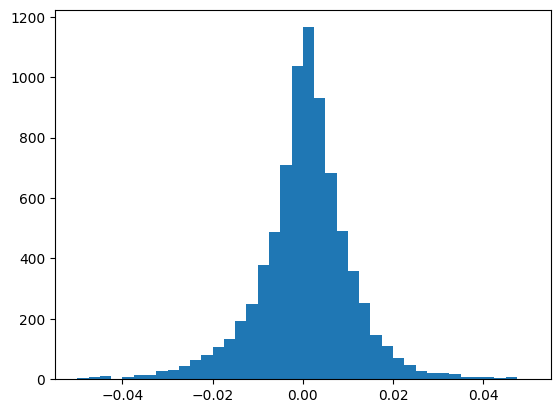

In [112]:
plt.hist(df_full['log_return'], bins=40, range=(-0.05, 0.05));
print(f'Mean: {df_full["log_return"].mean():.5f}')
print(f'SD: {df_full["log_return"].std():.5f}')

Mean: 0.00079 -2e-05 -5e-05 0.00066 0.00042 0.00059
SD: 0.00828 0.01428 0.01318 0.01191 0.00833 0.01299


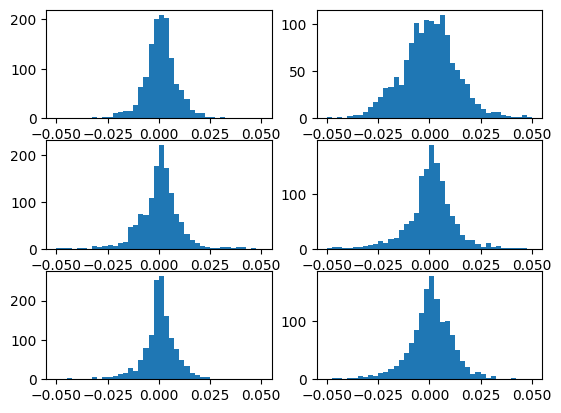

In [113]:
x = len(df_full['log_return']) // 6
means = []
stds = []
for i in range(1, 7):
    plt.subplot(3, 2, i)
    arr = df_full['log_return'][(i - 1) * x:i * x]
    plt.hist(arr, bins=40, range=(-0.05, 0.05));
    means.append(round(np.mean(arr), 5))
    stds.append(round(np.std(arr), 5))
print('Mean:', *means)
print('SD:', *stds)

In [114]:
x = len(df_month['log_return']) // 6
for i in range(6):
    arr = df_full['log_return'][i * x:(i + 1) * x].dropna()
    print(ttest_ind(df_full['log_return'].dropna(), arr).pvalue)

0.8343557523599668
0.9388578432866492
0.899720522275739
0.9911775464515058
0.44935567905615903
0.9356764749344


Here, we visualise the distributions of the log returns seperated by time intervals, to see if there is a trend over time. The ADF test in the ARIMA part shows that the series is stationary, and the p-values above show the p-value that 2 sets of data have the same mean, when comparing the entire distribution with the 6 different time periods. It is safe to say that the oldest data is not 'outdated' and can still be used. 

In [115]:
last_price = df_full.iloc[-1]['close_price']
future_days = [end_date + timedelta(days=i) for i in range(1, 1 + 365 * 20)]
rv = norm(loc=df_full['log_return'].mean(), scale=df_full['log_return'].std())
price_sim = []
returns_sim = rv.rvs(size=(len(future_days)) * 100, random_state=42)
for i in range(100):
    pred = [last_price]
    for j in range(len(future_days)):
        pred.append(pred[-1] * (np.e ** returns_sim[i * len(future_days) + j]))
    price_sim.append(pred[1:])

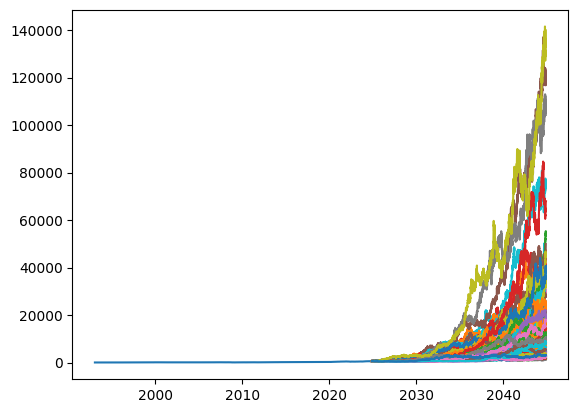

In [116]:
plt.plot(df_full['date'], df_full['close_price'])
for arr in price_sim:
    plt.plot(future_days, arr)

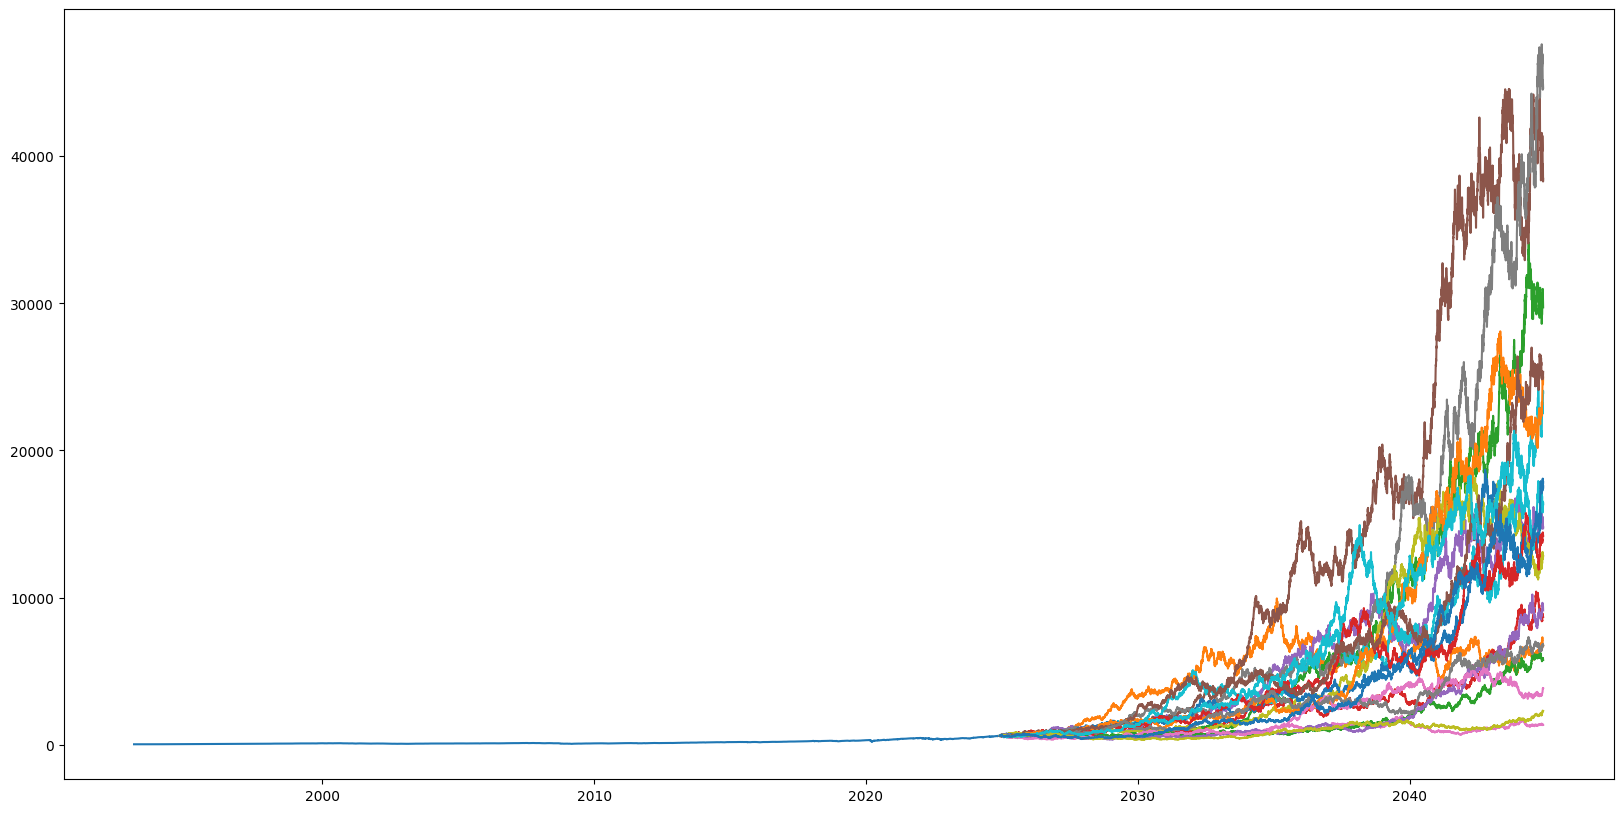

In [117]:
plt.figure(figsize=(20, 10))
plt.plot(df_full['date'], df_full['close_price'])
for i in range(0, len(price_sim), 5):  #Plot 20 out of 100 lines
    plt.plot(future_days, price_sim[i])

In [118]:
price_sim = sorted(price_sim, key=lambda arr: arr[-1])

In [119]:
final_prices = [arr[-1] for arr in price_sim]

In [120]:
print(f'Mean: {np.mean(final_prices)}\n'
      f'25pct: {final_prices[25]}\n'
      f'50pct: {final_prices[50]}\n'
      f'75pct: {final_prices[75]}')

Mean: 18952.665751247147
25pct: 4532.610827180327
50pct: 10708.803739241797
75pct: 24955.19781031383


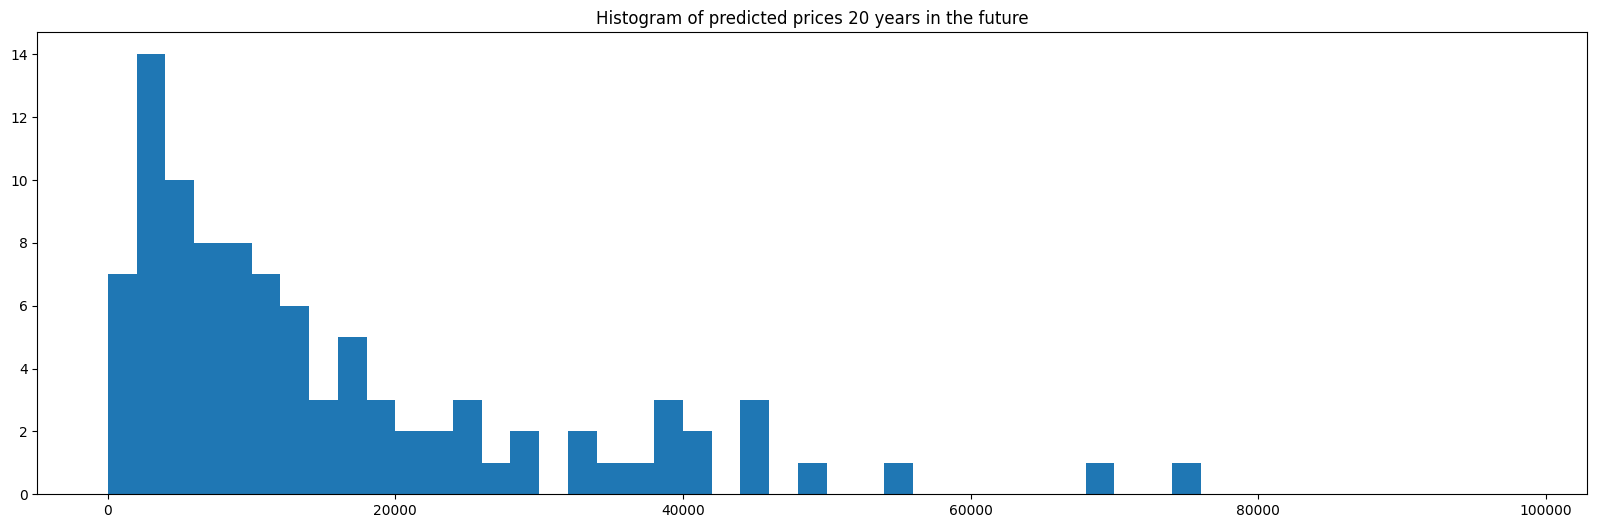

In [121]:
plt.figure(figsize=(20, 6))
plt.hist(final_prices, bins=[i * 2000 for i in range(50)])
plt.title('Histogram of predicted prices 20 years in the future');

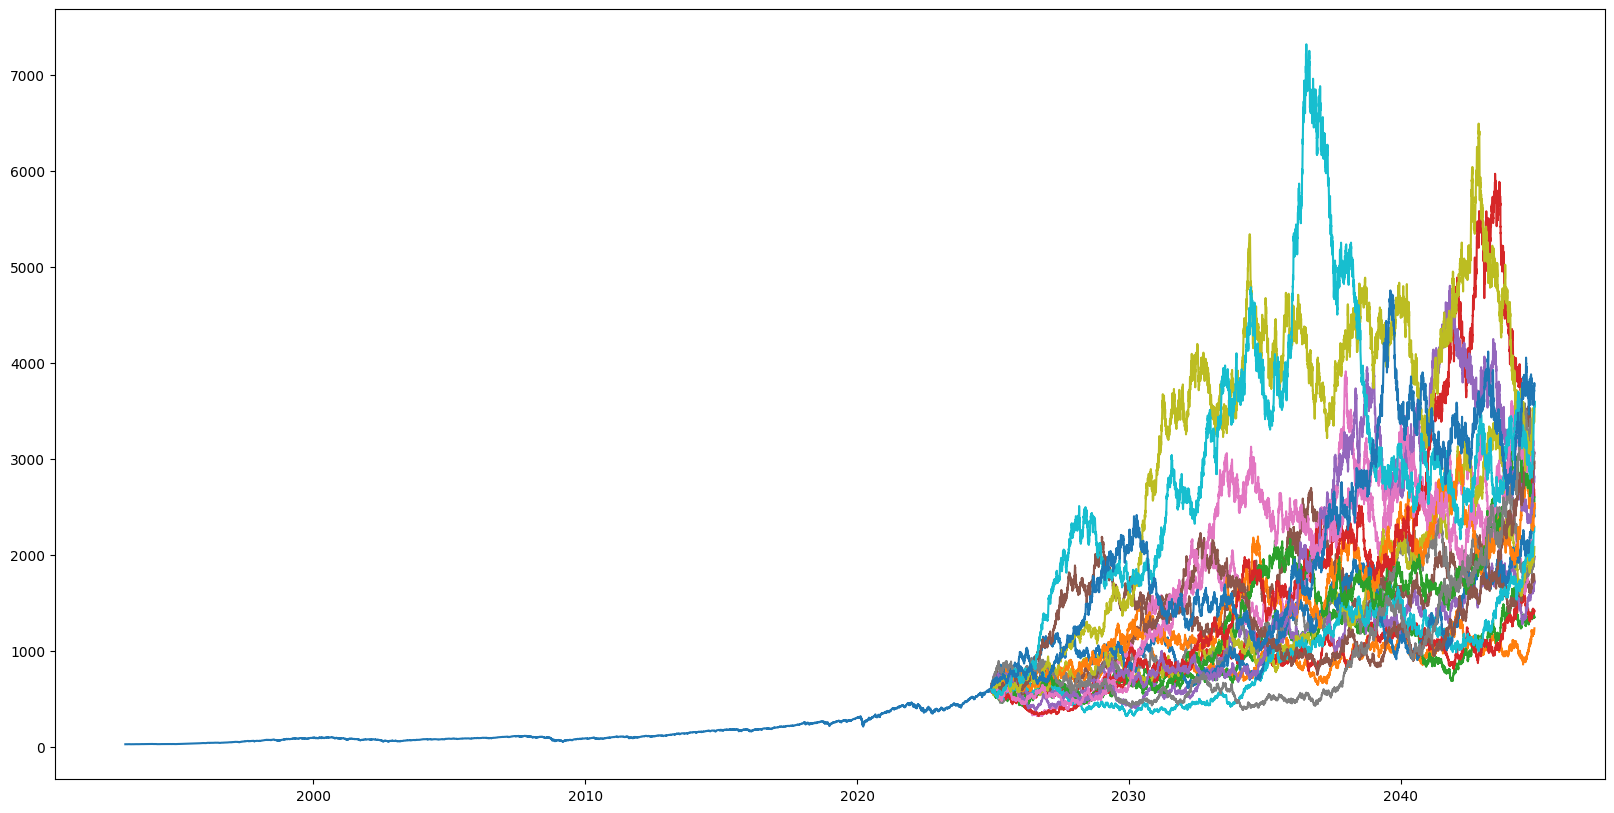

In [122]:
plt.figure(figsize=(20, 10))
plt.plot(df_full['date'], df_full['close_price'])
for i in range(20):
    plt.plot(future_days, price_sim[i])

In [123]:
final_prices=final_prices[:20]
print(f'Bottom 20\n'
      f'Mean: {np.mean(final_prices)}\n'
      f'Median {np.median(final_prices)}\n'
      f'Min: {final_prices[0]}\n'
      f'Max: {final_prices[-1]}')

Bottom 20
Mean: 2421.2179939008847
Median 2471.6321555720406
Min: 1233.5001632991068
Max: 3762.7836112761097


In [126]:
forecast = [np.mean([arr[i] for arr in price_sim[:20]]) for i in range(len(future_days))]

In [134]:
forecast_df = pd.concat([pd.Series(future_days), pd.Series(forecast)], axis=1)
forecast_df.columns = ['date', 'forecast']
forecast_df.to_csv('montecarlo_forecast.csv')